In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.tools.tools as stattools
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [218]:
# Load the dataset 
data = pd.read_csv('data_science_salaries.csv')
data.head

<bound method NDFrame.head of                      job_title experience_level employment_type work_models  \
0                Data Engineer        Mid-level       Full-time      Remote   
1                Data Engineer        Mid-level       Full-time      Remote   
2               Data Scientist     Senior-level       Full-time      Remote   
3               Data Scientist     Senior-level       Full-time      Remote   
4                 BI Developer        Mid-level       Full-time     On-site   
...                        ...              ...             ...         ...   
6594        Staff Data Analyst      Entry-level        Contract      Hybrid   
6595        Staff Data Analyst  Executive-level       Full-time     On-site   
6596  Machine Learning Manager     Senior-level       Full-time      Hybrid   
6597             Data Engineer        Mid-level       Full-time      Hybrid   
6598            Data Scientist     Senior-level       Full-time     On-site   

      work_year emplo

In [219]:
# Step 1: Find missing data
data.isnull().sum()

job_title             0
experience_level      0
employment_type       0
work_models           0
work_year             0
employee_residence    0
salary                0
salary_currency       0
salary_in_usd         0
company_location      0
company_size          0
dtype: int64

In [220]:
# Step 2: Check for duplicates and remove if any
data.duplicated().sum()

0

In [221]:
# Step 3: Encode categorical variables
categorical_cols = ['job_title', 'experience_level', 'employment_type', 
                    'work_models', 'employee_residence', 
                    'salary_currency', 'company_location', 'company_size']

# Dataset of only United States data
data = data[data['employee_residence'].str.contains('United States')]

# Step 4: Check for outliers in salary_in_usd using the IQR method
q1, q3 = data['salary_in_usd'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove rows with outliers in salary_in_usd
data_cleaned = data[(data['salary_in_usd'] >= lower_bound) & 
                            (data['salary_in_usd'] <= upper_bound)]

In [222]:
# Display summary of cleaned data
print(data_cleaned.info())
print(data_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5204 entries, 0 to 6556
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           5204 non-null   object
 1   experience_level    5204 non-null   object
 2   employment_type     5204 non-null   object
 3   work_models         5204 non-null   object
 4   work_year           5204 non-null   int64 
 5   employee_residence  5204 non-null   object
 6   salary              5204 non-null   int64 
 7   salary_currency     5204 non-null   object
 8   salary_in_usd       5204 non-null   int64 
 9   company_location    5204 non-null   object
 10  company_size        5204 non-null   object
dtypes: int64(3), object(8)
memory usage: 487.9+ KB
None
        job_title experience_level employment_type work_models  work_year  \
0   Data Engineer        Mid-level       Full-time      Remote       2024   
1   Data Engineer        Mid-level       Full-time      Remote 

In [223]:
data_cleaned['experience_level'].unique()

array(['Mid-level', 'Senior-level', 'Entry-level', 'Executive-level'],
      dtype=object)

In [224]:
data_cleaned.describe()

,work_year,salary,salary_in_usd
count,5204.000000,5204.000000,5204.000000
mean,2022.888163,153211.435050,153220.955419
std,0.590284,57568.049715,57552.569690
min,2020.000000,24000.000000,24000.000000
25%,2023.000000,110000.000000,110000.000000
50%,2023.000000,147000.000000,147000.000000
75%,2023.000000,190000.000000,190000.000000
max,2024.000000,318300.000000,318300.000000


Visualization

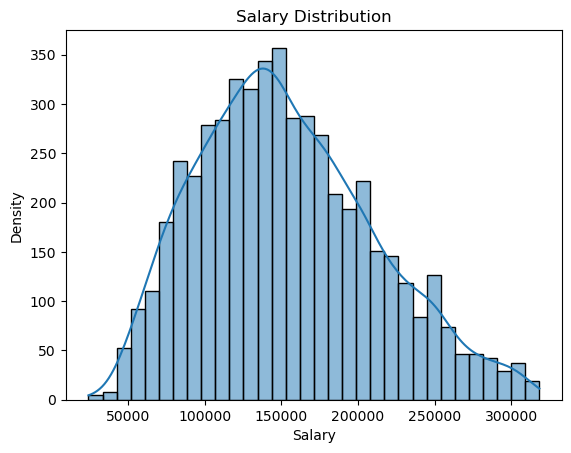

In [225]:
sns.histplot(data_cleaned['salary_in_usd'], kde=True)
plt.xlabel('Salary')
plt.ylabel('Density')
plt.title('Salary Distribution')
plt.show()

In [226]:
# Bin salary_in_usd into 4 categories
num_bins = 4
labels = ['Low', 'Medium', 'High', 'Very High']
data_cleaned['salary_binned'] = pd.qcut(data_cleaned['salary_in_usd'], q=num_bins, labels=labels)

/var/folders/6j/qtnqw_nn0bj948l89lgcc38m0000gn/T/ipykernel_70390/52521721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['salary_binned'] = pd.qcut(data_cleaned['salary_in_usd'], q=num_bins, labels=labels)


<Axes: ylabel='Frequency'>

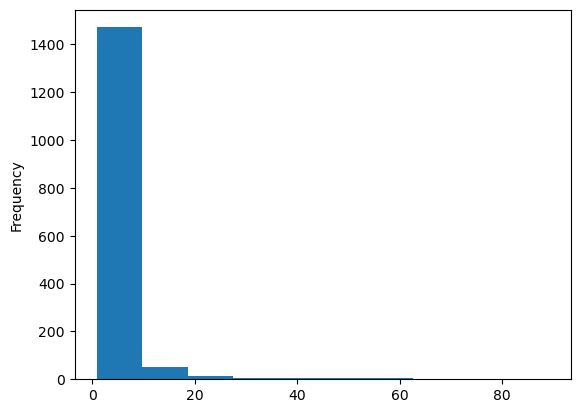

In [237]:
data_cleaned['salary_in_usd'].value_counts().plot(kind='hist')

In [244]:
salary_Small = data_cleaned[data_cleaned.company_size == 'Small']['salary_in_usd']
salary_Medium = data_cleaned[data_cleaned.company_size == 'Medium']['salary_in_usd']
salary_Large = data_cleaned[data_cleaned.company_size == 'Large']['salary_in_usd']

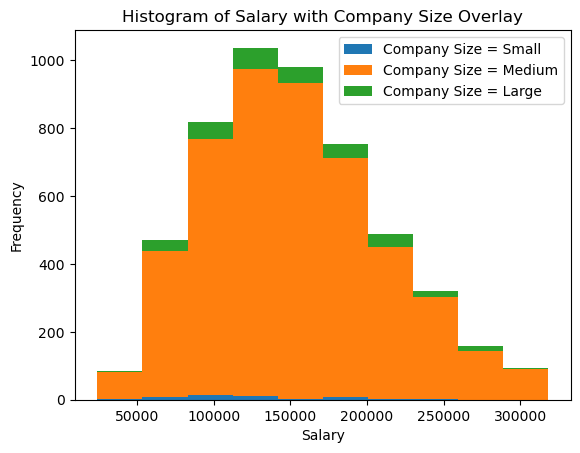

In [245]:
plt.hist([salary_Small, salary_Medium, salary_Large], bins=10, stacked=True)
plt.legend(['Company Size = Small', 'Company Size = Medium', 'Company Size = Large'])
plt.title('Histogram of Salary with Company Size Overlay')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

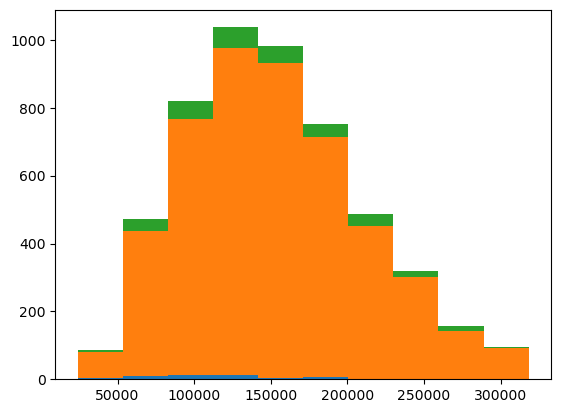

In [250]:
(n, bins, patches) = plt.hist([salary_Small, salary_Medium, salary_Large], bins = 10, stacked = True)
n_table = np.column_stack((n[0], n[1], n[2]))
n_norm = n_table / n_table.sum(axis=1)[:, None]
ourbins = np.column_stack((bins[:-1], bins[1:]))

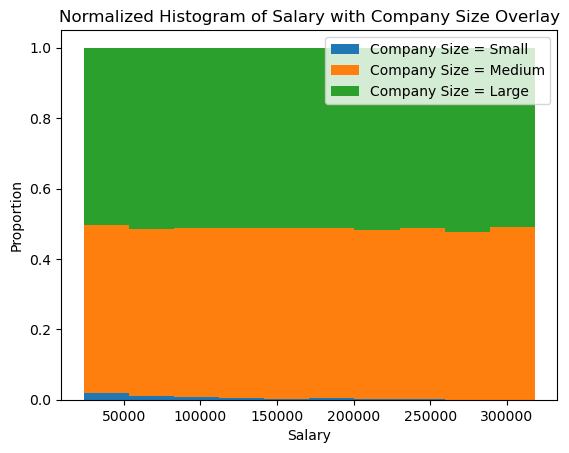

In [251]:
p1 = plt.bar(x=ourbins[:, 0], height=n_norm[:, 0], width=ourbins[:, 1] - ourbins[:, 0], align='edge', label='Small Company')
p2 = plt.bar(x=ourbins[:, 0], height=n_norm[:, 1], width=ourbins[:, 1] - ourbins[:, 0], align='edge', bottom=n_norm[:, 0], label='Medium Company')
p3 = plt.bar(x=ourbins[:, 0], height=n_norm[:, 2], width=ourbins[:, 1] - ourbins[:, 0], align='edge', bottom=n_norm[:, 0] + n_norm[:, 1], label='Large Company')

plt.legend(['Company Size = Small', 'Company Size = Medium', 'Company Size = Large'])
plt.title('Normalized Histogram of Salary with Company Size Overlay')
plt.xlabel('Salary') 
plt.ylabel('Proportion')
plt.show()

<Axes: xlabel='experience_level'>

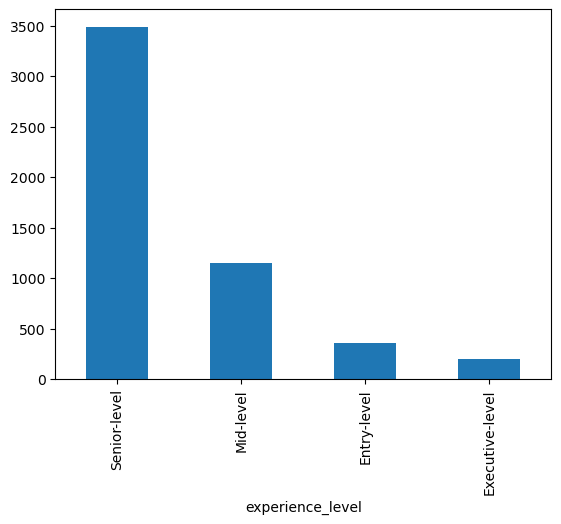

In [227]:
data_cleaned['experience_level'].value_counts().plot(kind='bar')

<Axes: xlabel='experience_level'>

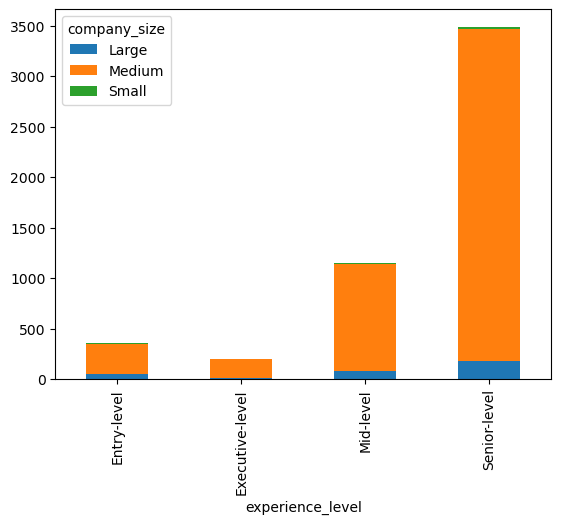

In [232]:
experience_salary = pd.crosstab(data_cleaned['experience_level'], data_cleaned['company_size'])
experience_salary.plot(kind='bar', stacked=True)

<Axes: xlabel='experience_level'>

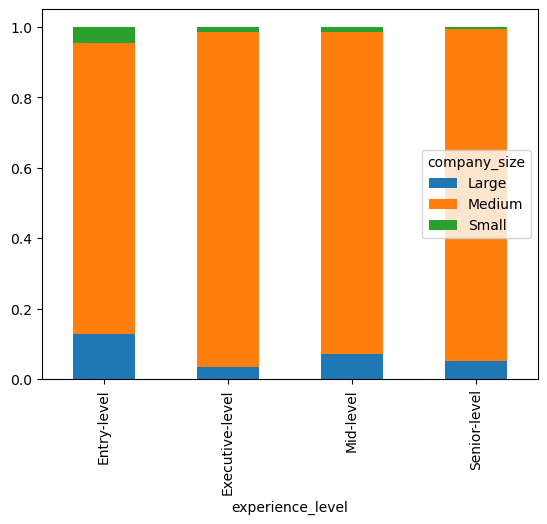

In [233]:
experience_salary_norm = experience_salary.div(experience_salary.sum(1), axis=0)
experience_salary_norm.plot(kind='bar', stacked=True)

In [235]:
conting_table = pd.crosstab(data_cleaned['company_size'], data_cleaned['experience_level'])
conting_table

experience_level,Entry-level,Executive-level,Mid-level,Senior-level
company_size,,,,
Large,46,7,81,177
Medium,299,191,1056,3297
Small,16,3,16,15


In [236]:
round(conting_table.div(conting_table.sum(0), axis=1)*100, 1)

experience_level,Entry-level,Executive-level,Mid-level,Senior-level
company_size,,,,
Large,12.7,3.5,7.0,5.1
Medium,82.8,95.0,91.6,94.5
Small,4.4,1.5,1.4,0.4


Split dataset to training and test

In [214]:
# Partition dataset 
data_train, data_test = train_test_split(data_cleaned, test_size = 0.20, random_state = 7)

In [215]:
# Confirm split proportions
split_proportions = pd.DataFrame({'Dataset': ['Training', 'Test'],
                                  'Proportion': [len(data_train) / len(data_cleaned), len(data_test) / len(data_cleaned)]
})

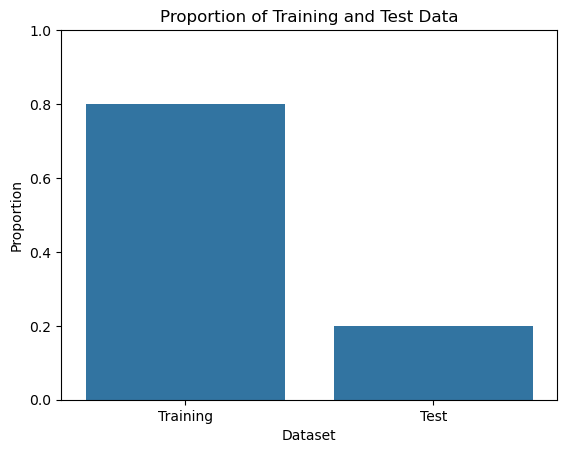

In [216]:
sns.barplot(x='Dataset', y='Proportion', data=split_proportions)

plt.title('Proportion of Training and Test Data')
plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.ylim(0, 1)
plt.show()

In [217]:
# Check dimensions of partitions


In [43]:
# Rebalance
to_resample = data_train.loc[data_train['job_title_Data Scientist'] == "True"]
our_resample = to_resample.sample(n = 1280, replace = True)
data_train_rebal = pd.concat([data_train, our_resample])


In [44]:
data_train_rebal['job_title_Data Scientist'].value_counts()

job_title_AI Scientist
False    5181
True     1292
Name: count, dtype: int64

In [61]:
# Confirm rebalancing
data_rebal_counts = data_train_rebal['job_title_Data Scientist'].value_counts()
data_proportions = data_rebal_counts / data_rebal_counts.sum()
data_proportions

job_title_Data Scientist
False    0.846903
True     0.153097
Name: count, dtype: float64

In [62]:
# Validate partition for difference in proportion of job_title_Data Scientist=True
data_test['job_title_Data Scientist'] = data_test['job_title_Data Scientist'].astype(str)

In [63]:
prop_data_train = (data_train['job_title_Data Scientist'] == 'True').mean()
prop_data_test = (data_test['job_title_Data Scientist'] == 'True').mean()
n_train = len(data_train)
n_test = len(data_test)
prop_combined = ((data_train['job_title_Data Scientist'] == 'True').sum() + (data_test['job_title_Data Scientist'] == 'True').sum()) / (n_train + n_test)
se = np.sqrt(prop_combined * (1 - prop_combined) * (1 / n_train + 1 / n_test))

In [64]:
# Two-tailed Z-test
Z_test = (prop_data_train - prop_data_test) / se
p_value = 2 * (1 - norm.cdf(abs(Z_test)))

print(f"Z-statistic: {Z_test:.4f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: 0.3728
P-value: 0.7093


C5.0 Model

In [78]:
job_scientist_encoded = pd.get_dummies(data_train['job_title_Data Scientist'])
job_scientist_encoded1 = pd.get_dummies(data_test['job_title_Data Scientist'])
comp_small_encoded = pd.get_dummies(data_train['company_size_Small'])
comp_small_encoded1 = pd.get_dummies(data_test['company_size_Small'])

,False,True
2799,1,0
1753,1,0
5344,1,0
5404,0,1
200,1,0
6138,1,0
64,1,0
1973,1,0
2445,1,0
3107,1,0


In [104]:
job_scientist_encoded = job_scientist_encoded.astype(int)
job_scientist_encoded1 = job_scientist_encoded1.astype(int)
comp_small_encoded = comp_small_encoded.astype(int)
comp_small_encoded1 = comp_small_encoded1.astype(int)
data_train[['company_size_Medium']] = data_train[['company_size_Medium']].astype(int)

In [105]:
y = data_train[['salary_in_usd']]
X = pd.concat((job_scientist_encoded, comp_small_encoded), axis = 1)
X_test = pd.concat((job_scientist_encoded1, comp_small_encoded1), axis = 1)

In [106]:
c50 = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=5).fit(X,y)

TypeError: Feature names are only supported if all input features have string names, but your input has ['bool', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [107]:
data['company_size']

0       Medium
1       Medium
2       Medium
3       Medium
4       Medium
         ...  
6594     Large
6595    Medium
6596     Large
6597     Large
6598     Small
Name: company_size, Length: 6599, dtype: object

In [243]:
data_cleaned['company_size'].unique()

array(['Medium', 'Large', 'Small'], dtype=object)